In [25]:
#######################################
###!@0 START INIT ENVIRONMENT #########

from google.colab import drive
drive.mount('/content/drive')

!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!tar xf /content/drive/MyDrive/nyc_data/python_modules/spark-3.0.3-bin-hadoop2.7.tgz
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.3-bin-hadoop2.7"

###!@0 END INIT ENVIRONMENT ###########

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
#######################################
###!@1 START OF PYSPARK INIT
import findspark
findspark.init()
findspark.find()
from pyspark.sql import SparkSession
spark = SparkSession.builder\
         .master("local")\
         .appName("Colab")\
         .config('spark.ui.port', '4050')\
         .getOrCreate()
spark
# Spark is ready to go within Colab!
###!@1 END OF PYSPARK INIT

In [27]:
#######################################
###!@2 START OF DEFINING INPUT FILES
tfile = "/content/drive/MyDrive/nyc_data/2021_chunk0.csv"
#tfile = "/content/drive/MyDrive/nyc_data/Parking_Violations_Issued_Fiscal_Year_2021.csv"
###!@2 END OF DEFINING INPUT FILES


#######################################
###!@3 START OF LOADING DATA
from pyspark import SparkContext, SparkConf
import sys

sc = SparkContext.getOrCreate()

##########################
# Load the NYC data into data frame
# nyc_data = sc.textFile(tfile)
nyc_data = spark.read.format("csv").option("header","true").load(tfile)

df = nyc_data.cache()
df.show(10)
df.printSchema()

#rowCount = df.count()
#print(f"{rowCount} rows loaded from file {tfile}")

###!@3 END OF LOADING DATA

+--------------+--------+------------------+----------+----------+--------------+-----------------+------------+--------------+------------+------------+------------+-----------------------+------------------+------------------+---------------+-----------+--------------+------------+--------------+-------------------+----------------+---------------------------------+------------+-------------------+-------------------+-------------------+-----------+------------+--------------------+----------------------+--------------------+------------------+-------------+---------------------+------------+------------+--------------+-------------------+---------------------+---------------------------------+-----------------+------------------------+
|Summons Number|Plate ID|Registration State|Plate Type|Issue Date|Violation Code|Vehicle Body Type|Vehicle Make|Issuing Agency|Street Code1|Street Code2|Street Code3|Vehicle Expiration Date|Violation Location|Violation Precinct|Issuer Precinct|Issuer 

**##### Common Imports and functions #####**

In [28]:
from operator import add
from functools import reduce

from pyspark.sql.types import IntegerType
from pyspark.sql.functions import col,lit, substring, when, concat_ws, to_timestamp, date_format, concat, to_date
import pyspark.sql.functions as F

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

def drop_null_columns(df, threshold=0):
    """
    This function drops all columns which contain null values more than threshold.
    :param df: A PySpark DataFrame
    :threshold: Minimum value of Null/None rows in a column
    """
    null_counts = df.select([F.count(F.when(F.col(c).isNull(), c).when(F.col(c).isNull(), c)).alias(c) for c in df.columns]).collect()[0].asDict()
    to_drop = [k for k, v in null_counts.items() if v > threshold]
    df = df.drop(*to_drop)
    return df

def is_identical_col(df, col1_name, col2_name):
  df_ident = df.withColumn("Identity_Flag", when(df[col1_name].cast('int') == df[col2_name].cast('int'), "true").otherwise("false"))
  df_unq = df_ident.select('Identity_Flag').distinct()
  return bool(df_unq.filter(df_unq.Identity_Flag.contains("false")).collect())

**##### Data Prep and Cleaning #####**


In [29]:
# Renaming column names to remove the whitespaces
current_columns = df.columns
#print(current_columns)
new_columns = list(map(lambda item : item.replace(" ","_"),current_columns))
#print(new_columns)
df_newCols = reduce(lambda data, idx: data.withColumnRenamed(current_columns[idx], new_columns[idx]), range(len(current_columns)), df)
#df_newCols.printSchema()
#df_newCols.show()



# Replacing '99' in Registration State column by None
df_r99 = df_newCols.withColumn("Registration_State", F.regexp_replace("Registration_State", '99', 'None'))
#df_r99.show()



# Replacing '999' in PlateType column by None
df_r999 = df_r99.withColumn("Plate_Type", F.regexp_replace("Plate_Type", '999', 'None'))
#df_r999.show()



# Replacing empty string in Violation_Location column by None
df_rEmptyVL = df_r999.withColumn("Violation_Location", when(col("Violation_Location")=="", 0).when(col("Violation_Location").isNull(), 0).otherwise(F.col("Violation_Location")))
#df_rEmptyVL.show()



# Replacing empty string in Violation_Precinct column by None
df_rEmptyVP = df_rEmptyVL.withColumn("Violation_Precinct", when(col("Violation_Precinct")=="", 0).otherwise(F.col("Violation_Precinct")))
#df_rEmptyVL.show()



# Deleting duplicate rows and duplicate SummonsNumber and making it unique
df_rmNull = df_rEmptyVP.dropna(thresh=int((len(df_rEmptyVP.columns)*0.8)))
df_rmDup  = df_rmNull.dropDuplicates()
df_rmDupSummons = df_rmDup.dropDuplicates(['Summons_Number'])
#df_rmDup.show()



# Drops columns if more than 80% values are null/None
thresh = int((df_rmDupSummons.count()) * 0.8)
df_rmDupSummons.cache()
df_dropNullCols = drop_null_columns(df_rmDupSummons, thresh)
#df_dropNullCols.show()



# Violation Code vs Violation Precinct - Drop Precinct if both columns have same value
if not is_identical_col(df_dropNullCols, "Violation_Location", "Violation_Precinct"):
  df_dropNullCols = df_dropNullCols.drop('Violation_Precinct')


#Valid Violation Location are only till 0 to 120 remove all the erroneous locations
df_dropNullCols = df_dropNullCols.withColumn("Violation_Location", df_dropNullCols["Violation_Location"].cast(IntegerType()))
df_validVL = df_dropNullCols.filter((df_dropNullCols.Violation_Location >= 0) &
                 (df_dropNullCols.Violation_Location <= 120))
#df_validVL.show()

# Get the date and time into proper datetime format - Issue_Date_Time
df_validVL = df_validVL.filter(F.length(col("Issue_Date")) == 10)
df_validVL = df_validVL.withColumn("Violation_Time", F.regexp_replace("Violation_Time", '[\s]', ''))
#df_validVL = df_validVL.withColumn(F.regexp_replace(F.col("Violation_Time"), "[\s]", ""))
df_validVL = df_validVL.filter(F.length(col("Violation_Time")) == 5)
df1 = df_validVL.withColumn('Issue_Date_Time', concat(concat_ws(' ',df_validVL['Issue_Date'], df_validVL['Violation_Time']), F.lit("M")))
df1 = df1.withColumn('Issue_Date_Time', F.from_unixtime(F.unix_timestamp(col("Issue_Date_Time"), "MM/dd/yyyy HHmma"), "yyyy-MM-dd HH:mm:ss"))
df1 = df1.filter(df1.Issue_Date_Time.isNotNull()).filter(df1.Issue_Date_Time != "")
#df1.show(5)


# Clean up the violation county column
# There are only 5 counties in NYC -- group all of these

remap_county_dict = {
    'K' : 'Brooklyn',
    'Q' : 'Queens',
    'NY': 'Manhattan',
    'QN': 'Queens',
    'Qns': 'Queens',
    'BK': 'Brooklyn',
    'R' : 'Staten Island',
    'BX': 'Bronx',
    'ST': 'Staten Island',
    'MN': 'Manhattan',
    'KINGS': 'Brooklyn',
    'Kings': 'Brooklyn',
    'QNS': 'Queens',
    'BRONX': 'Bronx',
    'RICH' : 'Staten Island',
    'F':'Brooklyn'
}

#Out of 280,000 rows, Violation county was null for almost 1100 datapoints, which is approx 0.4%
#Hence we remove the Null values
df2 = df1.replace(to_replace=remap_county_dict, subset=['Violation_County'])
df3 = df2.filter(df2.Violation_County.isNotNull())
#df4 = df3.groupBy("Violation_County").count().orderBy('count',ascending=False)
#df4.show(10)


# Adding Violation description and fine amount from lookup file
vcnf_file = "/content/drive/MyDrive/nyc_data/ParkingViolationCodes_January2020.csv"
vcnf_data = spark.read.format("csv").option("header","true").load(vcnf_file)
#vcnf_data.show()
df_vcnf = df3.join(vcnf_data, ['Violation_Code'], "left")

# Adding Violation Location Addresses from lookup file
vla_file = "/content/drive/MyDrive/nyc_data/Violation_Location_Address_Mapping.csv"
vla_data = spark.read.format("csv").option("header","true").load(vla_file)
#vla_data.show()
df_clean = df_vcnf.join(vla_data, ['Violation_Location'], "left")

df_clean.show(40)
df_clean.cache()

tmpOutputPath = "/content/drive/MyDrive/nyc_data/output/tmp/"
# Write DF to output
df_clean.orderBy(col("Issue_Date_Time")).coalesce(1).write.mode("overwrite").option("header",True).csv(tmpOutputPath + "NYC_2021_clean_data.csv")

#TODO Stats to be added
#print df/df_clean rows and columns
print(df_clean.count())



+------------------+--------------+--------------+----------+------------------+----------+----------+-----------------+------------+--------------+------------+------------+------------+-----------------------+---------------+-----------+--------------+------------+--------------+----------------+---------------------------------+------------+--------------------+-------------------+-----------+------------+----------------------+--------------------+------------------+-------------+------------+--------------+-------------------+-------------------+--------------------+-----------+--------------------+
|Violation_Location|Violation_Code|Summons_Number|  Plate_ID|Registration_State|Plate_Type|Issue_Date|Vehicle_Body_Type|Vehicle_Make|Issuing_Agency|Street_Code1|Street_Code2|Street_Code3|Vehicle_Expiration_Date|Issuer_Precinct|Issuer_Code|Issuer_Command|Issuer_Squad|Violation_Time|Violation_County|Violation_In_Front_Of_Or_Opposite|House_Number|         Street_Name|Date_First_Observed|L

In [30]:
# Adding Violation Location Addresses from lookup file
agency_file = "/content/drive/MyDrive/nyc_data/Agency_Code_Name_Mapping.csv"
agency_data = spark.read.format("csv").option("header","true").load(agency_file)
#vla_data.show()
df_clean = df_clean.join(agency_data, ['Issuing_Agency'], "left")

#**Question 1** 

# 1.a => At which particular hour of the day the most tickets were issued.

##### Return a dictionary of length 2 with values being the number of voilations in that hour.
##### 0=> 12AM-1AM, 1=> 1AM-2AM and so on.

+----------+------+
|Issue_Hour| count|
+----------+------+
|        00|  2520|
|        01|  4994|
|        02|  3252|
|        03|  2205|
|        04|  1530|
|        05|  1944|
|        06|  4981|
|        07| 61600|
|        08|147291|
|        09|132895|
|        10| 84032|
|        11|114439|
|        12| 94285|
|        23|     1|
+----------+------+



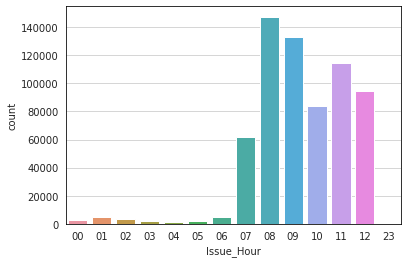

In [31]:
df1 = df_clean.withColumn('Issue_Hour', substring('Issue_Date_Time', 12, 2))
df1 = df1.groupBy('Issue_Hour').count().orderBy('Issue_Hour')
df1.show(25)

plt.clf()
sns.barplot(data=df1.toPandas(), y="count", x="Issue_Hour")
plt.show()

**Inference :** 

*   852846 tickets were issued between **08AM-09AM** which is highest for any hour
*   More than 90% of tickets are issues between **07AM-01PM**

# 1.b => During which season the most tickets were issued.

##### The season has been calculated based on month field of the Issue_Date_Time into 4 season.

* ##### *Winter* => 1 –> December, January and February.
* ##### *Spring* => 2 –> March, April and May.
* ##### *Summer* => 3 –> June, July and August.
* ##### *Fall* => 4 –> September, October and November.

+------+------+
|Season| count|
+------+------+
|Summer|588664|
|  Fall| 66841|
|Spring|   405|
|Winter|    59|
+------+------+



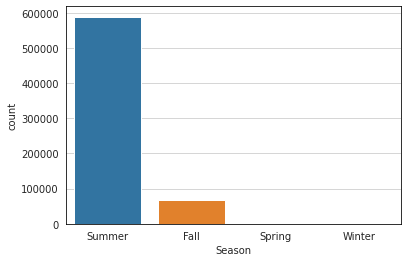

In [32]:
t_df = df_clean.withColumn('month', substring('Issue_Date_Time', 6, 2).cast('int'))

df1 = t_df.withColumn("Season", 
            when((col('month') == 12) | (col('month') <= 2), lit("Winter")).
            when((col('month') >= 3) & (col('month') <= 5), lit("Spring")).
            when((col('month') >= 6) & (col('month') <= 8), lit("Summer")).
            when((col('month') >= 9) & (col('month') <= 11), lit("Fall"))
              .otherwise(lit("others"))
            ).groupBy("Season").count().orderBy('count',ascending=False)

df1.show()

plt.clf()
sns.barplot(data=df1.toPandas(), y="count", x="Season")

plt.show()

**Inference:**

* Fall has max number of violations where as Winter has min number of violations.

# 1.c => Top 10 Violation Codes with highest number of summons

+--------------------+------+
|      Violation_Desc| count|
+--------------------+------+
|NO PARKING-STREET...|314061|
|FAIL TO DSPLY MUN...|108014|
|NO PARKING-DAY/TI...| 55144|
|NO STANDING-DAY/T...| 39456|
|NO STANDING-COMM ...| 28126|
|NO STANDING-EXC. ...| 27456|
|FAIL TO DISP. MUN...| 21090|
|  EXPIRED MUNI METER| 17979|
|DOUBLE PARKING-MI...|  8596|
|NO STANDING-EXC. ...|  8024|
+--------------------+------+
only showing top 10 rows



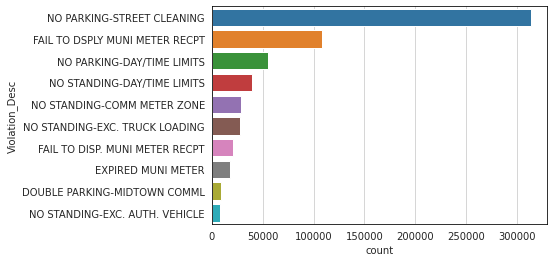

In [33]:
df1 = df_clean.groupBy("Violation_Desc").count().orderBy('count',ascending=False)
df1.show(10)

plt.clf()
sns.barplot(data=df1.toPandas().head(10), y="Violation_Desc", x="count")
plt.show()

**Inference:**

* Highest number of violations were made for Violation Code - (NO PARKING-STREET CLEANING)

# 1.d => Top 10 Vehicle Types with highest number of summons

+-----------------+------+
|Vehicle_Body_Type| count|
+-----------------+------+
|             SUBN|287396|
|             4DSD|195716|
|              VAN| 65186|
|              SDN| 33410|
|             PICK| 18815|
|             DELV| 16960|
|             2DSD| 15848|
|             REFG|  3003|
|             CONV|  2989|
|             null|  2528|
+-----------------+------+
only showing top 10 rows



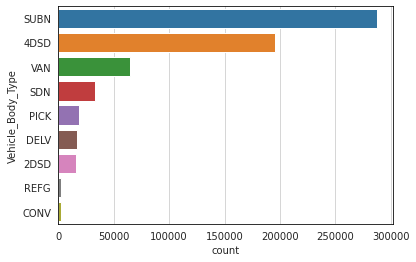

In [34]:
df1 = df_clean.groupBy("Vehicle_Body_Type").count().orderBy('count',ascending=False)
df1.show(10)

plt.clf()
sns.barplot(data=df1.toPandas().head(10), y="Vehicle_Body_Type", x="count")
plt.show()

**Inference:**

* Suburban (SUBN) vehicle body type has made the highest number of violations.

# 1.e => Top 10 Vehicle Makes with highest number of summons

+------------+-----+
|Vehicle_Make|count|
+------------+-----+
|       HONDA|82514|
|       TOYOT|76315|
|        FORD|69183|
|       NISSA|60653|
|       CHEVR|39999|
|        JEEP|28707|
|         BMW|28613|
|       ME/BE|27843|
|       DODGE|24336|
|       HYUND|20619|
+------------+-----+
only showing top 10 rows



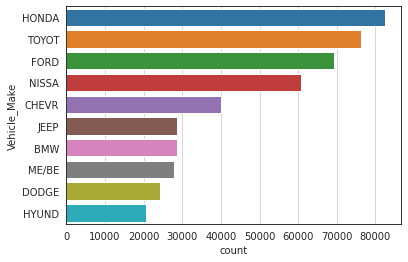

In [35]:
df1 = df_clean.groupBy("Vehicle_Make").count().orderBy('count',ascending=False)
df1.show(10)

plt.clf()
sns.barplot(data=df1.toPandas().head(10), y="Vehicle_Make", x="count")
plt.show()

**Inference:**

* HONDA vehicles has made the highets number of violations.

# 1.f => Top 10 Registration States with highest number of summons

+------------------+------+
|Registration_State| count|
+------------------+------+
|                NY|485270|
|                NJ| 63437|
|                PA| 24546|
|                FL| 13811|
|                CT|  9952|
|                TX|  6979|
|                MA|  5345|
|                VA|  4961|
|                NC|  4141|
|                MD|  3595|
+------------------+------+
only showing top 10 rows



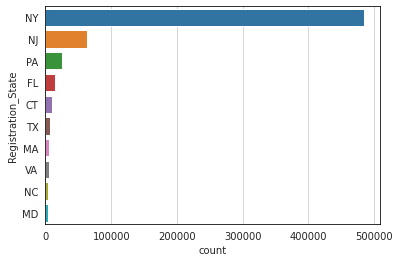

In [36]:
df1 = df_clean.groupBy("Registration_State").count().orderBy('count',ascending=False)
df1.show(10)

plt.clf()
sns.barplot(data=df1.toPandas().head(10), y="Registration_State", x="count")
plt.show()

**Inference:**

* The vehicles which have registration state as 'NY' makes approx 90% of violations.

# 1.g => Top 10 Agenices with highest number of summons

+--------------------+------+
|         Agency_Name| count|
+--------------------+------+
|             TRAFFIC|572910|
|DEPARTMENT OF SAN...| 58166|
|   POLICE DEPARTMENT| 21097|
|OTHER/UNKNOWN AGE...|  2490|
|    PARKS DEPARTMENT|   748|
|NYC TRANSIT AUTHO...|   253|
|   HOUSING AUTHORITY|   130|
|   TRANSIT AUTHORITY|    78|
|            CON RAIL|    47|
|TRIBOROUGH BRIDGE...|    28|
+--------------------+------+
only showing top 10 rows



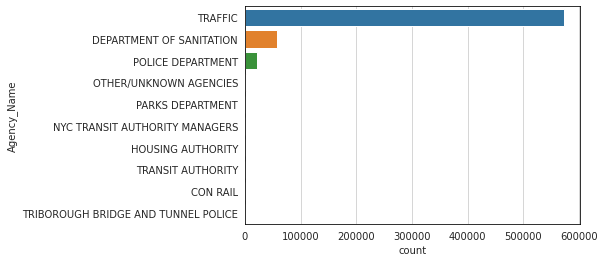

In [37]:
df1 = df_clean.groupBy("Agency_Name").count().orderBy('count',ascending=False)
df1.show(10)

plt.clf()
sns.barplot(data=df1.toPandas().head(10), y="Agency_Name", x="count")
plt.show()

**Inference:**

* 99.57% tickets were issued by 4 agencies (***T, S, P and X***)

# 1.h => Top 10 Locations with highest number of summons


+--------------------+-----+
|             Address|count|
+--------------------+-----+
|153 East 67th Street|33517|
|34-16 Astoria Bou...|30952|
|    No Address Found|21371|
|306 West 54th Street|19694|
|92-15 Northern Bo...|19019|
|230 East 21st Street|18361|
| 68-40 Austin Street|16457|
|  37-05 Union Street|16409|
| 154 Lawrence Avenue|15835|
|   16 Ericsson Place|15832|
+--------------------+-----+
only showing top 10 rows



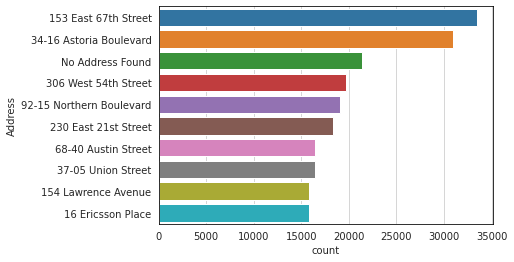

In [38]:
df1 = df_clean.groupBy("Address").count().orderBy('count',ascending=False)
df1.show(10)

plt.clf()
sns.barplot(data=df1.toPandas().head(10), y="Address", x="count")
plt.show()

**Inference:**

* Maxiumum violations were made at ***153 East 67th Street***.

# 1.i => Top 10 Plate Type with highest number of summons


+----------+------+
|Plate_Type| count|
+----------+------+
|       PAS|545405|
|       COM| 71255|
|       OMT| 17468|
|       OMS|  5402|
|      None|  4885|
|       SRF|  4271|
|       APP|  1642|
|       MOT|   970|
|       ORG|   796|
|       CMB|   638|
+----------+------+
only showing top 10 rows



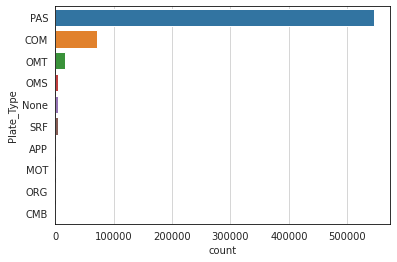

In [39]:
df1 = df_clean.groupBy("Plate_Type").count().orderBy('count',ascending=False)
df1.show(10)

plt.clf()
sns.barplot(data=df1.toPandas().head(10), y="Plate_Type", x="count")
plt.show()

**Inference:**

* Approx 75% violations were made by Passenger vehicles.
* Approx 15% violations were made by Commercial vehicles. 

# 2. => For which category of violations, the maximum number of tickets were issued and among them which state registered number plates have most tickets. [Limit to 10 violations]

In [40]:
df1 = df_clean.groupBy("Violation_Desc","Registration_State").count().orderBy('count',ascending=False)
#df1.show()

df2 = df1.groupBy('Violation_Desc').agg(F.max('count').alias('count'))
#df2.show()

df1.join(df2, ((df1['Violation_Desc'] == df2['Violation_Desc']) & (df1['count'] == df2['count'])), "leftsemi").show(truncate=False)


+------------------------------+------------------+------+
|Violation_Desc                |Registration_State|count |
+------------------------------+------------------+------+
|NO PARKING-STREET CLEANING    |NY                |240314|
|FAIL TO DSPLY MUNI METER RECPT|NY                |82015 |
|NO PARKING-DAY/TIME LIMITS    |NY                |39078 |
|NO STANDING-DAY/TIME LIMITS   |NY                |26227 |
|NO STANDING-EXC. TRUCK LOADING|NY                |19636 |
|FAIL TO DISP. MUNI METER RECPT|NY                |16886 |
|NO STANDING-COMM METER ZONE   |NY                |16586 |
|EXPIRED MUNI METER            |NY                |14799 |
|NO STANDING-EXC. AUTH. VEHICLE|NY                |6090  |
|DOUBLE PARKING-MIDTOWN COMML  |NY                |5887  |
|FIRE HYDRANT                  |NY                |2713  |
|OBSTRUCTING DRIVEWAY          |NY                |2450  |
|NGHT PKG ON RESID STR-COMM VEH|NY                |2312  |
|EXPIRED MUNI MTR-COMM MTR ZN  |NY                |2260 

**Inference:**

* NO PARKING-STREET CLEANING violations constitutes the highest number of violations and these violations were mostly made by Newyork City vehicles.

# 3. => Plot a time series graph for last 5 years showing total number of tickets per month and which season have maximum number of violations.

+-----------+------+
|Issue_Month| count|
+-----------+------+
|         01|    11|
|         02|    31|
|         03|    90|
|         04|    26|
|         05|   286|
|         06| 30099|
|         07|202157|
|         08|356288|
|         09| 66820|
|         10|     3|
|         11|     1|
|         12|     1|
+-----------+------+



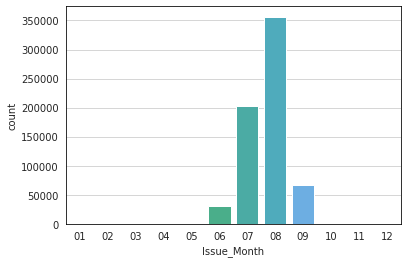

In [41]:
df = df_clean.filter(F.year(df_clean['Issue_Date_Time']) == '2020')
df1 = df.withColumn('Issue_Month', substring('Issue_Date_Time', 6, 2))
df1 = df1.groupBy('Issue_Month').count().orderBy('Issue_Month')

df1.show()

plt.clf()
sns.barplot(data=df1.toPandas(), y="count", x="Issue_Month")
plt.show()

***Inference:***

* **99.3%** Violations were made between **July to December** as compared **0.7%** violations between **January to June**.

# 4. => Repeated Violations

##### Dataset Columns of interest:
      Violation Code & Plate ID

##### Group the Violation code, Plate ID based on their occurence/frequency
##### Remove any violation code which has occured less that 2 times
##### Sort by frequency and print the table

+--------------------+--------+-----+
|      Violation_Desc|Plate_ID|count|
+--------------------+--------+-----+
|NO PARKING-DAY/TI...| 28509MH|   45|
|FAIL TO DISP. MUN...| 36435MM|   43|
|DOUBLE PARKING-MI...| 47602MD|   40|
|NO PARKING-DAY/TI...| 51536JW|   40|
|DOUBLE PARKING-MI...| 47603MD|   39|
|NO PARKING-DAY/TI...| 86445MB|   39|
|FAIL TO DISP. MUN...| 50444MM|   39|
|FAIL TO DISP. MUN...| 54341MK|   38|
|FAIL TO DISP. MUN...| 92391MH|   38|
|FAIL TO DISP. MUN...| 24292MM|   38|
+--------------------+--------+-----+
only showing top 10 rows



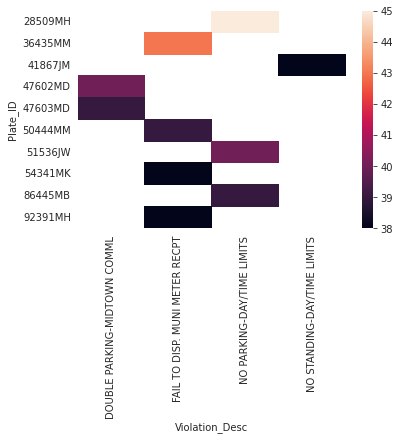

In [42]:
#Group by violation code
df_inp4 = df_clean.groupBy("Violation_Desc", "Plate_ID").count()

#Drop less than 2 violations as it will not be considered as repeated violation.
df_rpt = df_inp4.where(df_inp4["count"] > 1).where(df_inp4['Plate_ID'] != 'BLANKPLATE')

#Sort the data in descending order of count
df_ans4 = df_rpt.orderBy(F.desc("count"))

#print("Table for repeated violations from most to least frequent violation is as follows:")
df_ans4.show(10)


plt.clf()
df_wide = df_ans4.toPandas().head(10).pivot_table( index='Plate_ID', columns='Violation_Desc', values='count')
sns.heatmap(df_wide)
plt.show()


# Q5. => Number of tickets: New York vs other states registration

##### Dataset Columns of interest:
##### Registration State

##### Clean the column of registration state by Removing Null/None values
##### Filter NY registration state and Non-NY registration states
##### Count unique tickets for NY registration and Non-NY registration and display

Tickets for New York were 485270 as compared to other states 170699


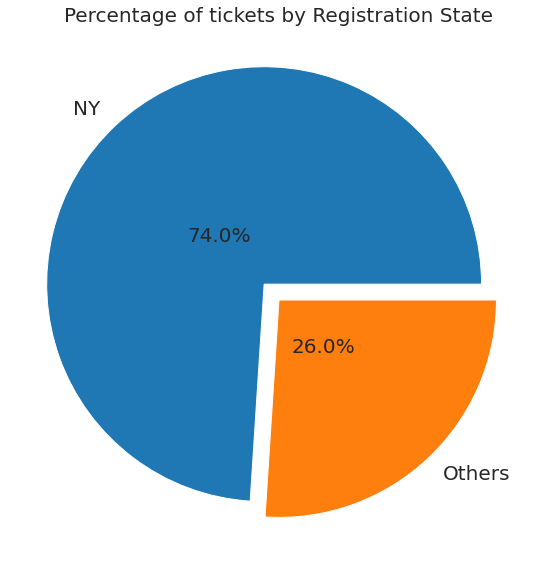

In [43]:
#Remove all the Invalid values from column Registration_State 
df_inp5 = df_clean
#df_inp5.show()

#Filter NY and Non-NY registered vehicles
#Label UNKNOWN to the fraction of registration states information not present in Dataset
df_inp5 = df_clean.withColumn("Registration_State_Category", when(col("Registration_State") == 'NY', "NY").otherwise(F.lit("Others")))


df_grp5 = df_inp5.groupBy("Registration_State_Category").count().orderBy('count',ascending=False)
#df_grp5.show()

explode=(0.1,0)

pie, ax = plt.subplots(figsize=[10,10])

plt.pie(x=df_grp5.toPandas()['count'], autopct="%.1f%%", explode=explode, labels=df_grp5.toPandas()['Registration_State_Category'] , pctdistance=0.3, textprops={'fontsize': 20})

plt.title("Percentage of tickets by Registration State", fontsize=20);

df_NY_Reg = df_inp5.where(df_inp5.Registration_State == "NY")
df_Othr_Reg = df_inp5.where(df_inp5.Registration_State != "NY")

ans5_NY_Cnt = df_NY_Reg.count()
ans5_Othr_Cnt = df_Othr_Reg.count()  

print("Tickets for New York were {} as compared to other states {}".format(ans5_NY_Cnt, ans5_Othr_Cnt))


# Q6. => Find the location at which maximum summons were issued who do not have number plates.

##### Dataset Columns of interest:
##### Summons Number
##### Violation Location
##### Plate ID


##### Approach is filter the plate IDs with BLANKPLATE to determine people who do not have number plates
##### group the reduced dataset with location
##### count number of summons at each location

+--------------+------------------+--------------+--------------+----------+------------------+----------+----------+-----------------+------------+------------+------------+------------+-----------------------+---------------+-----------+--------------+------------+--------------+----------------+---------------------------------+------------+-----------------+-------------------+-----------+------------+----------------------+--------------------+------------------+-------------+------------+--------------+-------------------+-------------------+--------------------+-----------+--------------------+--------------------+
|Issuing_Agency|Violation_Location|Violation_Code|Summons_Number|  Plate_ID|Registration_State|Plate_Type|Issue_Date|Vehicle_Body_Type|Vehicle_Make|Street_Code1|Street_Code2|Street_Code3|Vehicle_Expiration_Date|Issuer_Precinct|Issuer_Code|Issuer_Command|Issuer_Squad|Violation_Time|Violation_County|Violation_In_Front_Of_Or_Opposite|House_Number|      Street_Name|Date_F

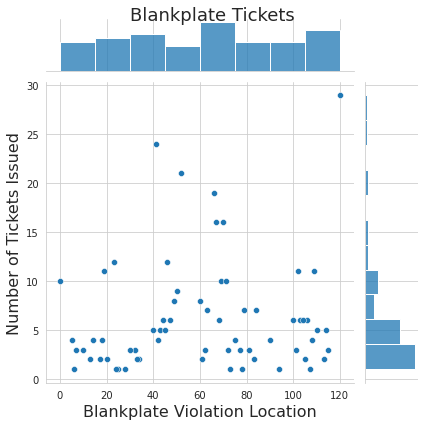

In [44]:
#from zmq.constants import NULL

#Filter the Plate_ID with BLANKPLATE, to show people who do not have number plates
#df_clean.show()
df_noPlate = df_clean.where(df_clean.Plate_ID=='BLANKPLATE')
df_noPlate.show()
#df_noPlate.show()
#print(df_noPlate.count())


#Group by violation location
df_loc = df_noPlate.groupBy("Violation_Location").count()
#df_loc.show()

#Sort the data in descending order of count
df_order = df_loc.orderBy(F.desc("count"))
vl = df_order.first()['Violation_Location']
vl_cnt = df_order.first()['count']

addr_dict = dict(df_noPlate.rdd.map(lambda r : (r.Violation_Location,r.Address)).collect())
print("Maximum summons {} were issued at this Address {} which is under location code {}, who do not have number plates".format(vl_cnt, addr_dict[vl], vl))

#Plots
sns.set_style('whitegrid')
h = sns.jointplot(x ='Violation_Location', y ='count', data = df_order.toPandas())
h.set_axis_labels('Blankplate Violation Location', 'Number of Tickets Issued', fontsize=16)
h.fig.suptitle("Blankplate Tickets" ,fontsize=18)
h.fig.tight_layout()
h.fig.subplots_adjust(top=0.95)


# **Q7 - What is the distribution of tickets across the 5 boroughs for the year?**

+----------------+------+
|Violation_County| count|
+----------------+------+
|       Manhattan|228922|
|        Brooklyn|180870|
|          Queens|155873|
|           Bronx| 89698|
|   Staten Island|   606|
+----------------+------+



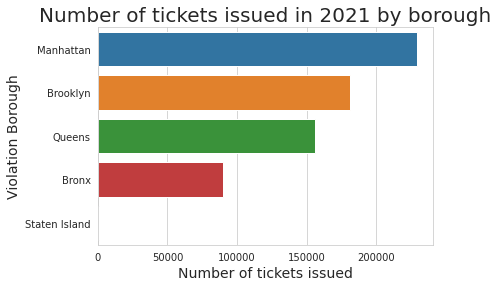

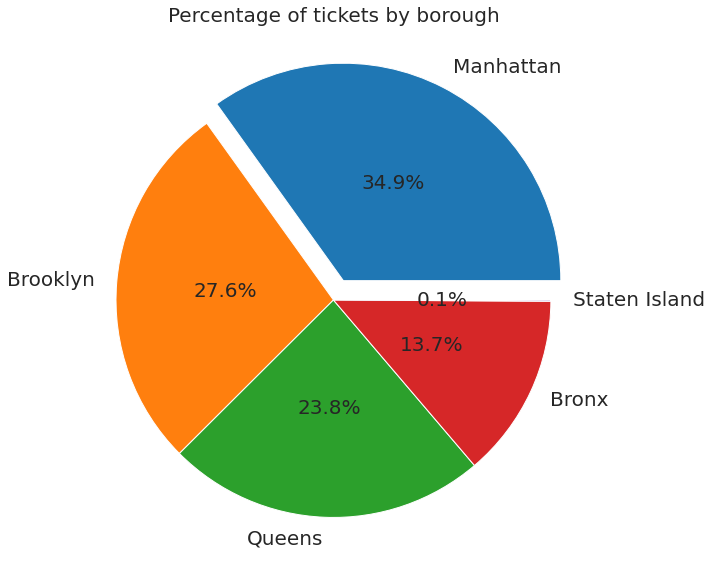

In [45]:
df1 = df_clean.groupBy("Violation_County").count().orderBy('count',ascending=False)
df1.show(10)

plt.clf()
sns.barplot(data=df1.toPandas(), y="Violation_County", x="count")
plt.title('Number of tickets issued in 2021 by borough', fontsize=20);
plt.ylabel('Violation Borough', fontsize=14)
plt.xlabel('Number of tickets issued', fontsize=14);
plt.show()

explode=(0.1,0,0,0,0)
pie, ax = plt.subplots(figsize=[10,10])
plt.pie(x=df1.toPandas()['count'], autopct="%.1f%%", explode=explode, labels=df1.toPandas()['Violation_County'], pctdistance=0.5, textprops={'fontsize': 20})
plt.title("Percentage of tickets by borough", fontsize=20);


The largest ticket issuer is **Manhattan** and the lowest is **Staten Island**.

* Manhattan is one of the most densly populated areas of NYC with over 71,000 people per square mile and private parking garages costing several hundered and even thousands per month.

* Staten Island is a more rural borough of NYC, with a population density of just over 8,000 people per square mile. Many of the homes are houses with driveways and garages and shopping centers often have parking lots -- all features whih are absent in the other boroughs of NYC

# **Q8 - What days of the week are most tickets issued?**

Text(0.5, 1.0, 'Average tickets issued by day of the week')

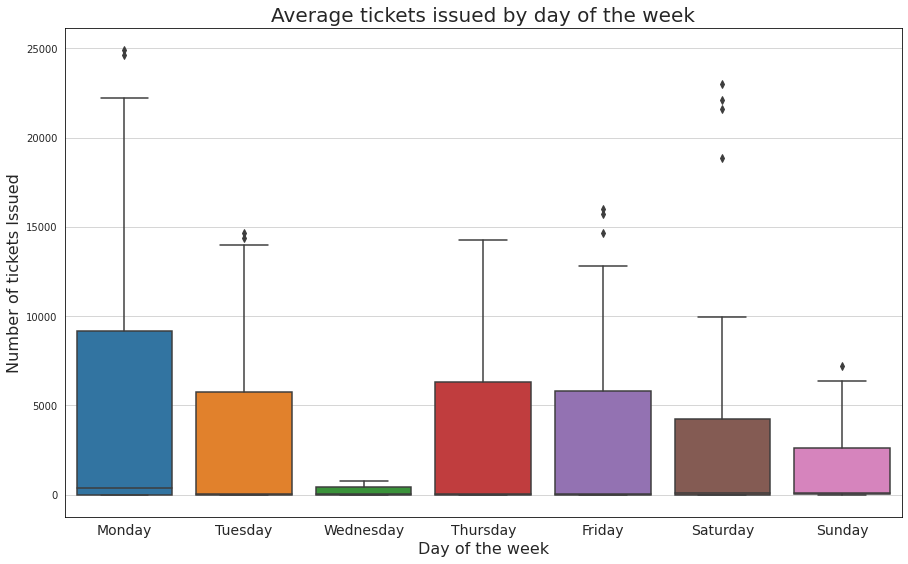

In [46]:
df1 = df_clean.withColumn('Issue_Date', substring('Issue_Date_Time', 0, 10))
df1 = df1.groupBy('Issue_Date').count().orderBy('Issue_Date')
df1 = df1.filter(F.year(df1['Issue_Date']) == '2020')
#df1.show()

import pandas as pd

plt.figure(figsize=(15, 9))
sns.set_style({'axes.linewidth': 2, 'axes.edgecolor':'black'}) #this adds the black line box (spine) around the plot
ax = sns.boxplot(x=pd.to_datetime(df1.toPandas()['Issue_Date']).dt.day_name(), y='count', data= df1.toPandas())
ax.set_xticklabels(labels=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'], fontsize=14)
ax.set_xlabel('Day of the week', fontsize=16)
ax.set_ylabel('Number of tickets Issued', fontsize=16)
ax.set_title('Average tickets issued by day of the week', fontsize=20)


**Inference:**

* In the plot we see that least number of tickets were issues on Friday.

* Tuesday takes the lead with a mean value of over 10,000 ticklets issued throughout the city

# **Q9 - What is the overall income that NYC makes on tickets?**

In [47]:
df_clean.agg(F.sum('Fine_Amount').cast('decimal(20,2)').alias('Total_Fine_Amount_for_2021')).show()

+--------------------------+
|Total_Fine_Amount_for_2021|
+--------------------------+
|               48363580.00|
+--------------------------+



The total fines ticketed amount to $314 million dollars for fiscal year 2021 across all 5 boroughs.